In [1]:

from utils.trainfiles import TrainFiles
from utils.dataloader import DataLoader
from model.unet import UNet

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if torch.cuda.is_available():
    print('GPU ready')
else:
    print('Warning: only CPU found')

GPU ready


# Generate trainfiles.json

In [2]:
trainfiles = TrainFiles('trainfiles.json',True)
trainfiles.find_files('/home/stephan/Desktop/',['.stk'])

# Train UNet

In [2]:
trainfiles = TrainFiles('trainfiles.json',False)
dataloader = DataLoader(trainfiles,batch_size=5,n_pre=3,n_post=3,train_height=400,train_width=400,load_multiple_targets_per_file=True,n_multiple_targets=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(6).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.L1Loss()


In [3]:
# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    i = 0
    while not dataloader.epoch_done:
        batch_generated = dataloader.get_batch()
        if not batch_generated:
            break
        data = dataloader.X.to(device)
        targets = dataloader.y.to(device)
        model.train()
        outputs = model(data)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(f'Batch {i+1}, Loss: {loss.item()}')
        i += 1
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    dataloader.shuffle_array()

Batch 1, Loss: 0.7212199568748474


In [3]:
dataloader.get_batch()

True

In [6]:
dataloader.X[0].shape

torch.Size([6, 400, 400])

In [6]:
np.divide(np.subtract(test, 0.5), 0.01)

array([[[-36.03860401,  16.97301643,  24.31719335, ...,  -9.1975101 ,
          37.6840328 ,   1.4155125 ],
        [-19.25347392,  35.38362072,  41.38119842, ...,  32.14723143,
          33.70736365,  29.97620627],
        [  5.88093066,  23.24414489, -37.93562049, ..., -45.19172356,
         -42.98951076, -11.29427185],
        ...,
        [ 20.2289089 ,  33.33691451,  49.39696261, ...,  -9.4052512 ,
         -43.95066086,   2.30343383],
        [ 14.8859829 , -25.89038994,   6.41091053, ..., -46.13492949,
         -30.61153373, -37.66802848],
        [ 44.94354844,  16.01521511,  47.45763701, ...,  -5.7847362 ,
         -30.05405856, -19.73441243]],

       [[-46.88375149,  40.85343238,  18.05265708, ...,  31.82928718,
          12.38697782,  32.29281785],
        [-47.70731643, -15.73917262,  33.16170257, ...,  -1.7008825 ,
         -44.21229681,  -9.33526551],
        [ 37.99785996,  37.95958301,  47.51285004, ...,  -2.10098969,
          38.62032559, -26.30654235],
        ...,


In [11]:
_ = dataloader_.get_batch()
X_test = dataloader_.X.to(device)
y_test = dataloader_.y


In [16]:
import numpy as np
model.eval()

y_pred = np.array(model(X_test).detach().to('cpu'))

In [27]:
mean = np.mean(y_pred)
std = np.std(y_pred)

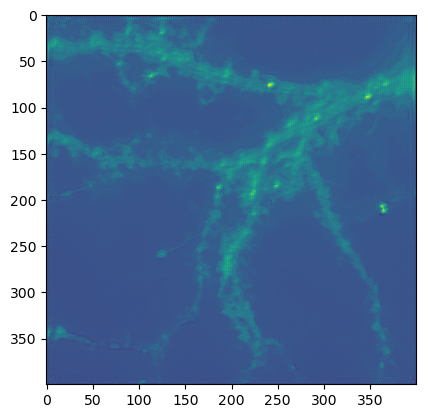

In [30]:
z_ = np.divide(np.subtract(y_pred,mean),std)
plt.imshow(z_[0][0])

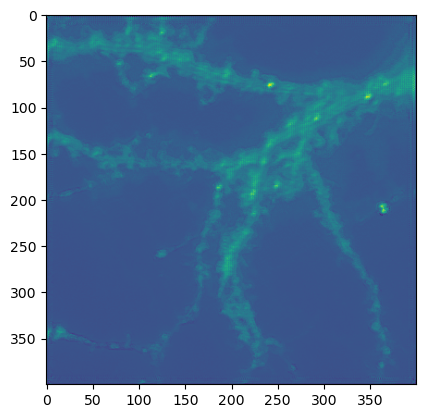

In [19]:
import matplotlib.pyplot as plt
plt.imshow(y_pred[0][0])